<a href="https://colab.research.google.com/github/HILALOZTEMEL/Deep-Learning-for-Face-Mask-Detection/blob/main/FaceMask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Gerekli Kütüphanelerin Yüklenmesi

In [ ]:
# Gerekli kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# Veri Setinin Yüklenmesi ve Ön İşleme

In [ ]:
data_path = '/content/drive/MyDrive/YAPAY SİNİR AĞLARI/data'

In [ ]:
# Initialize lists for images (x) and labels (y)
x, y = [], []
counter = 0

# Get the class labels
classes = os.listdir(data_path)
print(classes)

['without_mask', 'with_mask']


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_rows, img_cols = 224, 224  # Target image size

# Iterate through directories
for class_path in os.listdir(data_path):
    class_folder_path = os.path.join(data_path, class_path)
    if os.path.isdir(class_folder_path):
        for img_path in os.listdir(class_folder_path):
            img_full_path = os.path.join(class_folder_path, img_path)
            try:
                print(f"Processing: {img_full_path}")
                # Load and preprocess image
                image = load_img(img_full_path, target_size=(img_rows, img_cols))
                image = img_to_array(image)
                x.append(image)
                y.append(counter)
            except Exception as e:
                print(f"Error processing {img_full_path}: {e}")
    counter += 1

# Convert to numpy arrays
x = np.array(x)
y = np.array(y)
print(f"Loaded {len(x)} images with labels {len(y)}.")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/without_mask/without_mask_676.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/without_mask/without_mask_822.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/without_mask/without_mask_901.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/without_mask/without_mask_654.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/without_mask/without_mask_906.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/without_mask/without_mask_639.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/without_mask/without_mask_576.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/without_mask/without_mask_767.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/without_mask/without_mask_857.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/without_mask/without_mask_6

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/with_mask/with_mask_3164.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/with_mask/with_mask_3167.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/with_mask/with_mask_315.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/with_mask/with_mask_3169.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/with_mask/with_mask_3171.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/with_mask/with_mask_3134.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/with_mask/with_mask_3154.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/with_mask/with_mask_3139.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/with_mask/with_mask_3175.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/with_mask/with_mask_3166.jpg
Processing: /content/drive/MyDrive/YAPAY SİNİR AĞLARI/data/with_mask/with_mask_3157.jpg


In [ ]:
print(y)

[0 0 0 ... 1 1 1]


In [ ]:
from sklearn.model_selection import train_test_split

# İlk olarak veri setini eğitim ve geçici set olarak böl
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# Geçici seti de eğitim ve doğrulama setlerine böl
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42, shuffle=True)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (4833, 224, 224, 3), y_train shape: (4833,)
x_val shape: (1209, 224, 224, 3), y_val shape: (1209,)
x_test shape: (1511, 224, 224, 3), y_test shape: (1511,)


veri seti sınıflar sıralı bir şekilde yer alıyorsa (örneğin, **ilk yarısı without_mask, ikinci yarısı with_mask**), karıştırma olmadan bölme işlemi, eğitim ve test/validation setlerinde yalnızca bir sınıfın bulunmasına neden olabilir.
**shuffle=False** durumunda s**ınıflar dengesiz bir şekilde bölünebilir** ve bu da **modelin yalnızca bir sınıfı öğrenmesine yol açabilir.**


In [ ]:
# Eğitim setindeki sınıf dağılımını kontrol et
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("Eğitim seti sınıf dağılımı:", dict(zip(unique_train, counts_train)))

# Doğrulama setindeki sınıf dağılımını kontrol et
unique_val, counts_val = np.unique(y_val, return_counts=True)
print("Doğrulama seti sınıf dağılımı:", dict(zip(unique_val, counts_val)))

# Test setindeki sınıf dağılımını kontrol et
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Test seti sınıf dağılımı:", dict(zip(unique_test, counts_test)))

Eğitim seti sınıf dağılımı: {0: 2438, 1: 2395}
Doğrulama seti sınıf dağılımı: {0: 611, 1: 598}
Test seti sınıf dağılımı: {0: 779, 1: 732}


In [ ]:
# Rescale validation and test data
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test/255.0

In [ ]:
# Görüntü boyutu ve batch size
image_size = (224, 224)
batch_size = 32

# Eğitim veri artırımı
datagen_train = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_generator = datagen_train.flow(
    x_train,  # Giriş görüntüleri
    y_train,  # Sınıf etiketleri
    batch_size=32  # Eğitim sırasında kullanılacak batch boyutu
)

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2438, 1: 2395}


# Pre-Trained Model1'in Oluşturulması


1.   Adam optimizer, learning_rate=0.001
2.   binary_crossentropy
3.   DenseNet121



In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Model tabanı
base_model1 = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Özelleştirilmiş katmanlar
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions1 = Dense(1, activation='sigmoid')(x)  # Çıkış softmax aktivasyonlu

# Modeli oluştur
model1 = Model(inputs=base_model1.input, outputs=predictions1)

# Adam optimizatörü tanımla
optimizer1 = Adam(learning_rate=0.001)

# Modeli derle
model1.compile(optimizer=optimizer1, loss='binary_crossentropy', metrics=['accuracy'])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Model1'in Eğitilmesi

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks tanımları
early_stopping1 = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Model eğitimi
history1 = model1.fit(
    train_generator,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[early_stopping1, reduce_lr1]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/152 ━━━━━━━━━━━━━━━━━━━━ 331s 991ms/step - accuracy: 0.9149 - loss: 0.2060 - val_accuracy: 0.7204 - val_loss: 5.7582 - learning_rate: 0.0010
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 297ms/step - accuracy: 0.9770 - loss: 0.0791 - val_accuracy: 0.6336 - val_loss: 2.3468 - learning_rate: 0.0010
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 48s 298ms/step - accuracy: 0.9707 - loss: 0.0918 - val_accuracy: 0.5567 - val_loss: 0.8158 - learning_rate: 0.0010
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 298ms/step - accuracy: 0.9844 - loss: 0.0582 - val_accuracy: 0.5087 - val_loss: 2.2831 - learning_rate: 0.0010
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 297ms/step - accuracy: 0.9818 - loss: 0.0616 - val_accuracy: 0.4946 - val_loss: 23.3254 - learning_rate: 0.0010
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 295ms/step - accuracy: 0.9843 - loss: 0.0528 - val_accuracy: 0.4946 - val_loss: 29.0456 - learning_rate: 0.0010
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 300ms/step - accuracy: 0.988

# Pre-Trained Model2'in Oluşturulması


1.   Adam optimizer, learning_rate=0.0001
2.   binary_crossentropy
3.   EfficientNetB0


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

base_model2 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions2 = Dense(1, activation='sigmoid')(x)

# Modeli oluştur
model2 = Model(inputs=base_model2.input, outputs=predictions2)

# Adam optimizatörü tanımla
optimizer2 = Adam(learning_rate=0.0001)

# Modeli derle
model2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])





# Model2'in Eğitilmesi

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks tanımları
early_stopping2 = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Model eğitimi
history2 = model2.fit(
    train_generator,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[early_stopping2, reduce_lr2]
)

Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 177s 609ms/step - accuracy: 0.7411 - loss: 0.4906 - val_accuracy: 0.5054 - val_loss: 0.8413 - learning_rate: 1.0000e-04
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 293ms/step - accuracy: 0.9779 - loss: 0.0668 - val_accuracy: 0.6824 - val_loss: 0.5488 - learning_rate: 1.0000e-04
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 293ms/step - accuracy: 0.9878 - loss: 0.0401 - val_accuracy: 0.7593 - val_loss: 0.5531 - learning_rate: 1.0000e-04
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 293ms/step - accuracy: 0.9924 - loss: 0.0238 - val_accuracy: 0.5186 - val_loss: 27.6785 - learning_rate: 1.0000e-04
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 293ms/step - accuracy: 0.9974 - loss: 0.0128 - val_accuracy: 0.4864 - val_loss: 306.7759 - learning_rate: 1.0000e-04
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 293ms/step - accuracy: 0.9968 - loss: 0.0163 - val_accuracy: 0.5029 - val_loss: 912.9838 - learning_rate: 1.0000e-04
Epoch 7/100
151/152 ━━━━━━━━━━━━━━

# Pre-Trained Model3'ün Oluşturulması


1.   SGD optimizer, learning_rate=0.001, momentum=0.9
2.   binary_crossentropy
3.   DenseNet121




In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

# Model tabanı
base_model3 = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Özelleştirilmiş katmanlar
x = base_model3.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions3 = Dense(1, activation='sigmoid')(x)

# Modeli oluştur
model3 = Model(inputs=base_model3.input, outputs=predictions3)

# Optimizer olarak SGD veya Adam kullanabilirsiniz
optimizer3 = SGD(learning_rate=0.001, momentum=0.9)  # SGD örneği
# optimizer = Adam(learning_rate=0.001)  # Alternatif olarak Adam

# Modeli derle
model3.compile(optimizer=optimizer3, loss='binary_crossentropy', metrics=['accuracy'])


# Model3'in Eğitilmesi

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks tanımları
early_stopping3 = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)


# Model eğitimi
history3 = model3.fit(
    train_generator,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[early_stopping3, reduce_lr3]
)

Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 251s 814ms/step - accuracy: 0.7120 - loss: 0.5160 - val_accuracy: 0.9735 - val_loss: 0.0757 - learning_rate: 0.0010
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 296ms/step - accuracy: 0.9932 - loss: 0.0247 - val_accuracy: 0.9578 - val_loss: 0.1137 - learning_rate: 0.0010
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 294ms/step - accuracy: 0.9937 - loss: 0.0201 - val_accuracy: 0.4946 - val_loss: 3.3204 - learning_rate: 0.0010
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 295ms/step - accuracy: 0.9940 - loss: 0.0212 - val_accuracy: 0.4946 - val_loss: 3.8812 - learning_rate: 0.0010
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 295ms/step - accuracy: 0.9963 - loss: 0.0130 - val_accuracy: 0.4839 - val_loss: 4.1980 - learning_rate: 0.0010
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9924 - loss: 0.0264
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
152/152 ━━━━━━━━━━━━━━━━━━━━ 48s 305ms/step - accurac

# Eğitim ve Validasyon Sonuçlarının Görselleştirilmesi

Model 1:
* Adam optimizer, learning_rate=0.001
* categorical_crossentropy

Model 2:
* Adam optimizer learning_rate=0.0001
* binary_crossentropy

Model 3:
* SGD optimizer, learning_rate=0.001, momentum=0.9
* binary_crossentropy

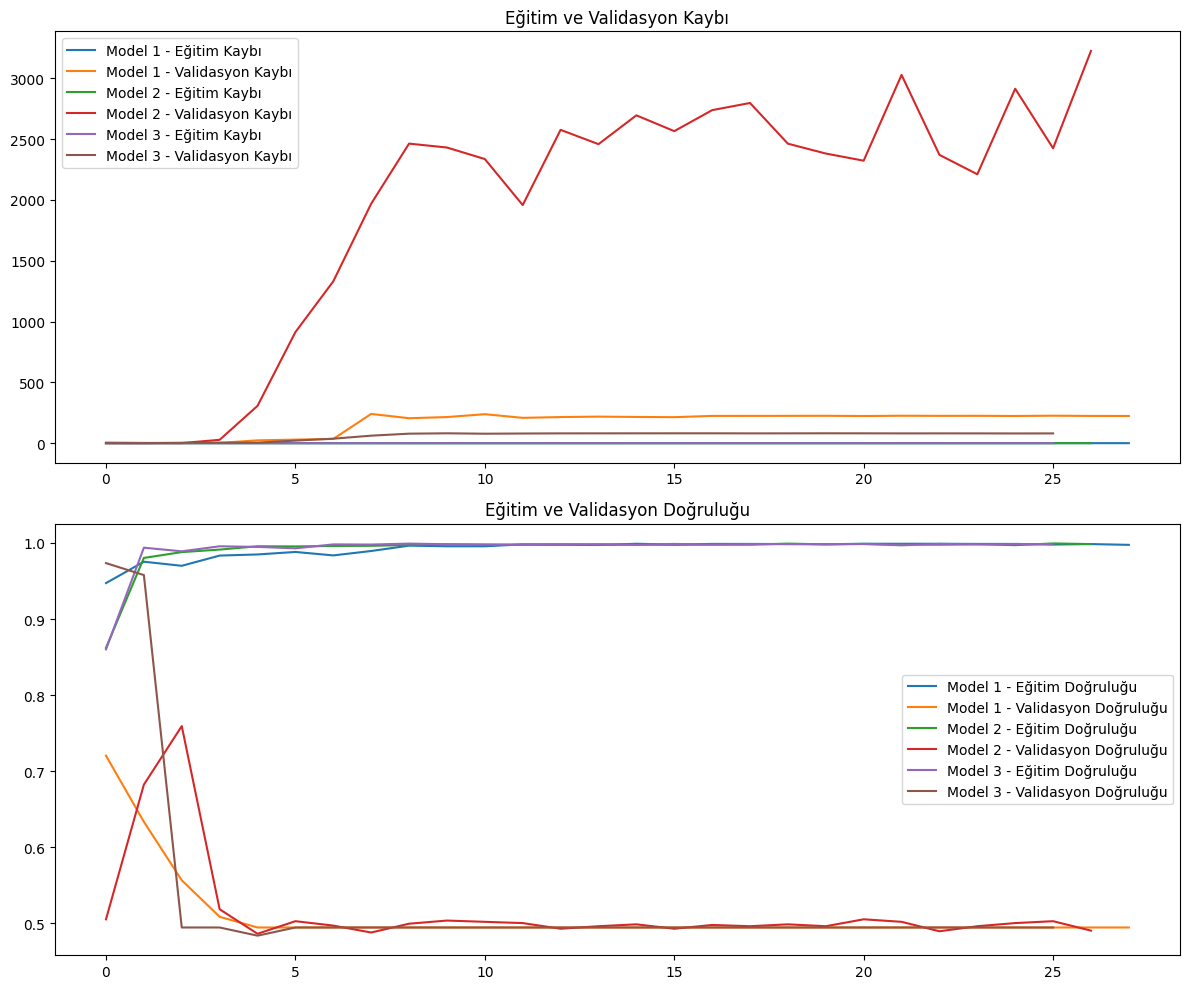

In [ ]:
# 3 modelin history verileri: history1, history2, history3
plt.figure(figsize=(12, 10))

# Eğitim ve validasyon kaybı
plt.subplot(2, 1, 1)
plt.plot(history1.history['loss'], label='Model 1 - Eğitim Kaybı')
plt.plot(history1.history['val_loss'], label='Model 1 - Validasyon Kaybı')
plt.plot(history2.history['loss'], label='Model 2 - Eğitim Kaybı')
plt.plot(history2.history['val_loss'], label='Model 2 - Validasyon Kaybı')
plt.plot(history3.history['loss'], label='Model 3 - Eğitim Kaybı')
plt.plot(history3.history['val_loss'], label='Model 3 - Validasyon Kaybı')
plt.legend()
plt.title('Eğitim ve Validasyon Kaybı')

# Eğitim ve validasyon doğruluğu
plt.subplot(2, 1, 2)
plt.plot(history1.history['accuracy'], label='Model 1 - Eğitim Doğruluğu')
plt.plot(history1.history['val_accuracy'], label='Model 1 - Validasyon Doğruluğu')
plt.plot(history2.history['accuracy'], label='Model 2 - Eğitim Doğruluğu')
plt.plot(history2.history['val_accuracy'], label='Model 2 - Validasyon Doğruluğu')
plt.plot(history3.history['accuracy'], label='Model 3 - Eğitim Doğruluğu')
plt.plot(history3.history['val_accuracy'], label='Model 3 - Validasyon Doğruluğu')
plt.legend()
plt.title('Eğitim ve Validasyon Doğruluğu')

plt.tight_layout()
plt.show()

# Test Sonuçlarının Analizi


### Model 1 ###
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


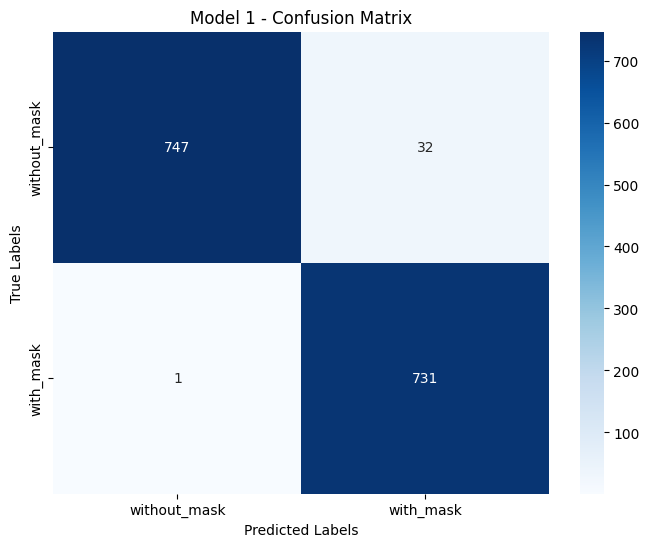

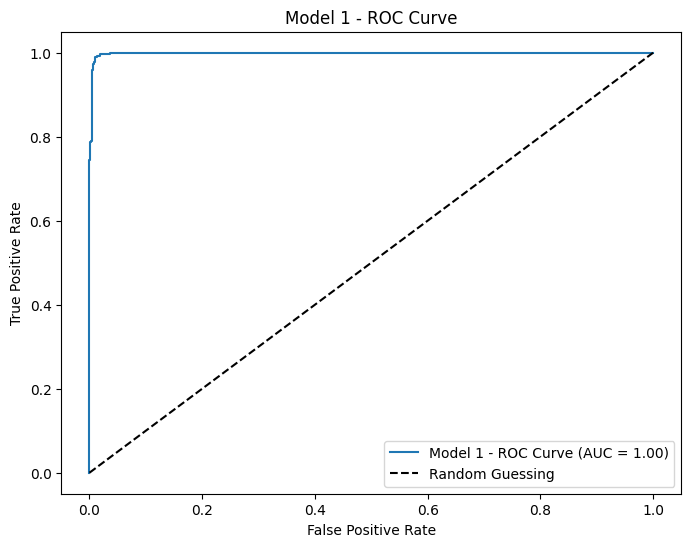

Classification Report:
              precision    recall  f1-score   support

without_mask       1.00      0.96      0.98       779
   with_mask       0.96      1.00      0.98       732

    accuracy                           0.98      1511
   macro avg       0.98      0.98      0.98      1511
weighted avg       0.98      0.98      0.98      1511


### Model 2 ###
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


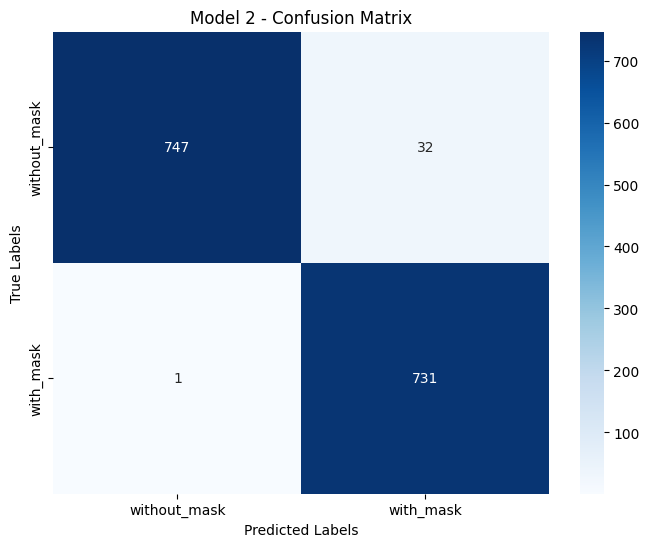

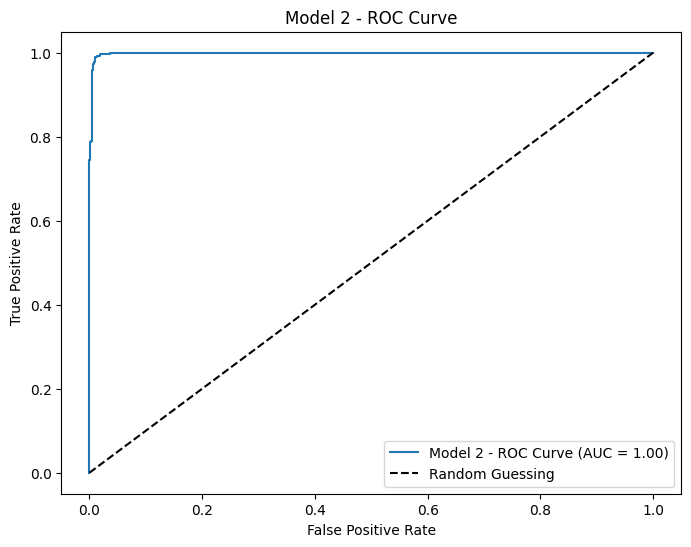

Classification Report:
              precision    recall  f1-score   support

without_mask       1.00      0.96      0.98       779
   with_mask       0.96      1.00      0.98       732

    accuracy                           0.98      1511
   macro avg       0.98      0.98      0.98      1511
weighted avg       0.98      0.98      0.98      1511


### Model 3 ###
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


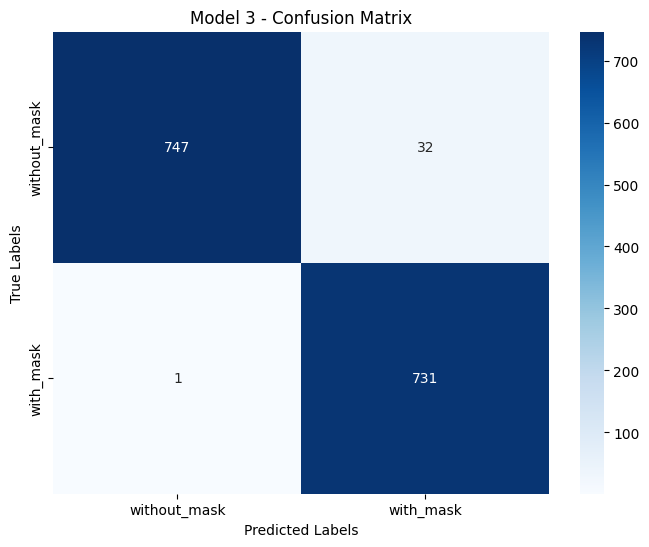

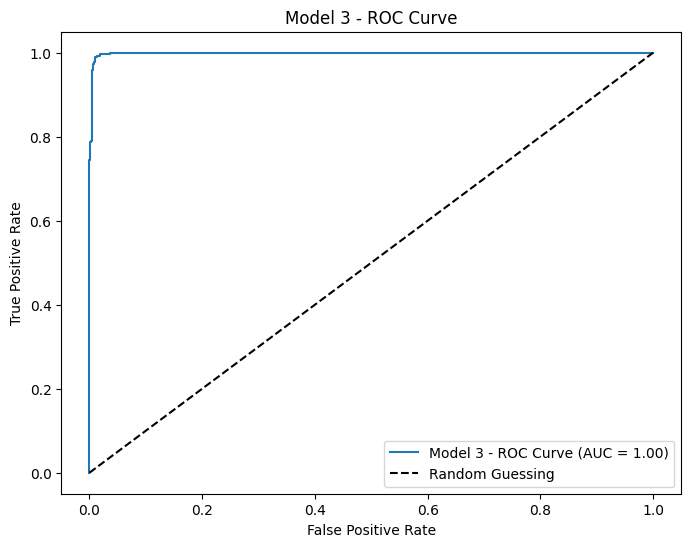

Classification Report:
              precision    recall  f1-score   support

without_mask       1.00      0.96      0.98       779
   with_mask       0.96      1.00      0.98       732

    accuracy                           0.98      1511
   macro avg       0.98      0.98      0.98      1511
weighted avg       0.98      0.98      0.98      1511



In [ ]:
# Sınıf etiketleri
class_labels = ['without_mask', 'with_mask']

# Üç modelin tahminlerini ve gerçek etiketlerini alıyoruz
models = [model1, model2, model3]  # Modellerin listesi
model_names = ["Model 1", "Model 2", "Model 3"]  # Model isimleri

for i, model in enumerate(models):
    print(f"\n### {model_names[i]} ###")

    # Test seti üzerinde tahmin
    #y_pred = model.predict(x_test)  # Model tahminleri
    #y_pred_classes = np.argmax(y_pred, axis=1)  # Tahmin edilen sınıf etiketleri
    # Test seti üzerinde tahmin
    #y_pred = model.predict(x_test).ravel()  # Model tahminleri (ravel ile düzleştiriyoruz)
    #y_pred_classes = (y_pred > 0.5).astype("int32")  # 0 veya 1 olarak sınıflandır
    y_pred= model3.predict(x_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    y_true = y_test  # Gerçek sınıf etiketleri

    # Karışıklık Matrisi
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_names[i]} - Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # ROC ve AUC
    y_pred_prob = y_pred.ravel()  # Olasılıkları düzleştir
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_names[i]} - ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_names[i]} - ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Performans Metrikleri
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))